# 機械学習を用いた株価予測のデモ（その２）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from pandas_datareader import data as pdr
from datetime import date, datetime, timedelta
import yfinance as yf

In [2]:
# yahooサイトからデータをダウンロード
ticker = '9984.T' # 9984はソフトバンクグループ
end_date = datetime.today()
start_date = end_date - timedelta(days=180)
yf.pdr_override()
data = pdr.get_data_yahoo(ticker, start_date, end_date)
close_prices_AAPL = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Reverse the order of the data
close_prices_AAPL_reverse = close_prices_AAPL # No Reverse
#close_prices_AAPL_reverse = close_prices_AAPL.iloc[::-1]

# Reset index to maintain the correct time series order in the plot
close_prices_AAPL_reverse.reset_index(drop=True, inplace=True)

# Data preprocessing
data = close_prices_AAPL_reverse.values.reshape(-1, 1)  # Reshape the data
data_normalized = data / np.max(data)  # Normalize the data

# Split the data into training and testing sets
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

In [4]:
# Function to create LSTM model
def create_lstm_model(units, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(1, 1)))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [5]:
# Define hyperparameters for tuning
lstm_units = [50, 100, 200]
lstm_activations = ['relu', 'tanh']
learning_rates = [0.001, 0.01, 0.1]
epochs = 100
batch_size = 32

# Perform hyperparameter tuning for LSTM model
best_rmse = float('inf')
best_lstm_model = None

for units in lstm_units:
    for activation in lstm_activations:
        for learning_rate in learning_rates:
            # Create and train LSTM model
            model = create_lstm_model(units=units, activation=activation, learning_rate=learning_rate)
            model.fit(train_data[:-1].reshape(-1, 1, 1), train_data[1:], epochs=epochs, batch_size=batch_size, verbose=0)

            # Predict on test data
            test_predictions = model.predict(test_data[:-1].reshape(-1, 1, 1)).flatten()

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test_data[1:], test_predictions))

            # Check if current model has lower RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_lstm_model = model

# Predict on the entire dataset using the best LSTM model
all_lstm_predictions = best_lstm_model.predict(data_normalized[:-1].reshape(-1, 1, 1)).flatten()

# Inverse normalize the LSTM predictions
all_lstm_predictions = all_lstm_predictions * np.max(data)

# Calculate the scaling factor based on the maximum value of the original data
scaling_factor = np.max(close_prices_AAPL_reverse)



4/4 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 17ms/step


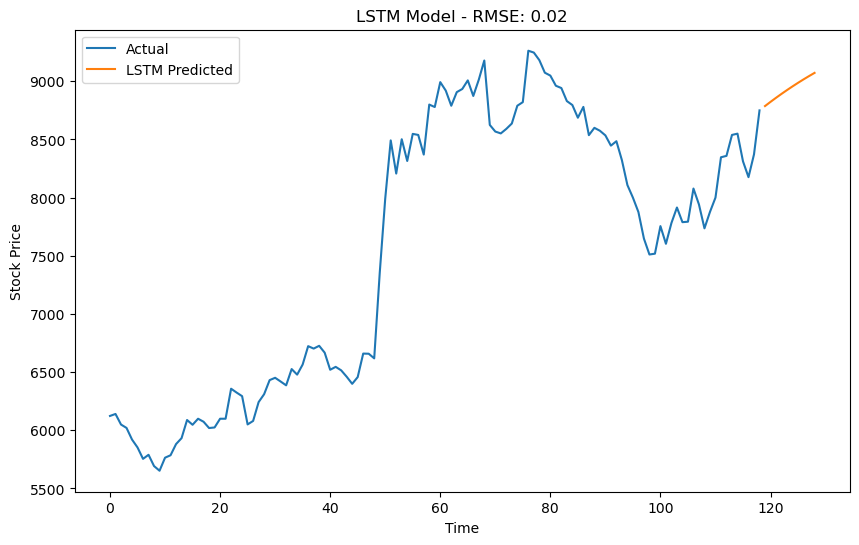

Predicted stock prices for the next 10 days:
Day 1: 8787.20
Day 2: 8823.27
Day 3: 8858.21
Day 4: 8892.04
Day 5: 8924.76
Day 6: 8956.41
Day 7: 8986.99
Day 8: 9016.52
Day 9: 9045.02
Day 10: 9072.50


In [6]:
# Function to predict future stock prices using the LSTM model
def predict_future_lstm(model, data, num_predictions, scaling_factor):
    predictions = []

    # Get the last data point from the input data
    last_data_point = data[-1]

    for _ in range(num_predictions):
        # Predict the next time step
        prediction = model.predict(last_data_point.reshape(1, 1, 1))
        predictions.append(prediction[0, 0])

        # Update last_data_point to include the predicted value for the next iteration
        last_data_point = np.append(last_data_point[1:], prediction)

    # Inverse normalize the predictions
    predictions = np.array(predictions) * scaling_factor

    return predictions

# Predict the next 10 days using the LSTM model
num_predictions = 10
lstm_predictions = predict_future_lstm(best_lstm_model, data_normalized, num_predictions, scaling_factor)

# Plot the LSTM predictions for the next 10 days
plt.figure(figsize=(10, 6))
plt.plot(close_prices_AAPL_reverse, label='Actual')
plt.plot(np.arange(len(close_prices_AAPL_reverse), len(close_prices_AAPL_reverse) + num_predictions), lstm_predictions, label='LSTM Predicted')
plt.title(f"LSTM Model - RMSE: {best_rmse:.2f}")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print the predicted stock prices for the next 10 days using LSTM
print("Predicted stock prices for the next 10 days:")
for i, prediction in enumerate(lstm_predictions, start=1):
    print(f"Day {i}: {prediction:.2f}")